In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

(-0.5, 4675.5, 4674.5, -0.5)

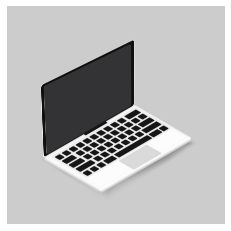

In [2]:
# read RGB image 
img = cv2.cvtColor(cv2.imread('laptop_black.jpg'), cv2.COLOR_BGR2RGB)

# plot image
plt.imshow(img)
plt.axis('off')

In [3]:
# Definie source triangle
A = [int(img.shape[1]/3), int(img.shape[0]/4)]
B = [int(img.shape[1]*3/4), int(img.shape[0]/2)]
C = [int(img.shape[1]/2), int(img.shape[0]/4*3)]
src_anotation_label = ['A', 'B', 'C']
src_triangle = np.array([A, B, C])

In [4]:
def plot_triangle_with_labels(img, triangle, anotation_label, fill = True, ax = plt):
    
    # plot image
    ax.imshow(img)
    
    # fill triangle
    if fill:
        ax.fill_between(np.concatenate((triangle[:,0], [triangle[:,0][0]])), 
                         np.concatenate((triangle[:,1], [triangle[:,1][0]])), alpha = 0.5)
        
    # annotate triangle
    ax.scatter(triangle[:,0], triangle[:,1], color = 'tab:orange' )
    for i, txt in enumerate(anotation_label):
        ax.annotate(txt, (triangle[:,0][i], triangle[:,1][i]), bbox=dict(boxstyle='circle, pad=0.2', fc='white', alpha=0.7),)
    ax.axis('off')

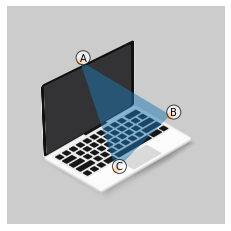

In [5]:
# plot source triangle
plot_triangle_with_labels(img, src_triangle, src_anotation_label)

In [6]:
# Definie destination triangle
A_prim = [0, int(img.shape[0]/2)]
B_prim = [int(img.shape[1]*4/5), int(img.shape[0]/3)]
C_prim = [int(img.shape[1]/2), int(img.shape[0]*4/5)]
dst_anotation_label = ["A'", "B'","C'",]
dst_triangle = np.array([A_prim, B_prim, C_prim])

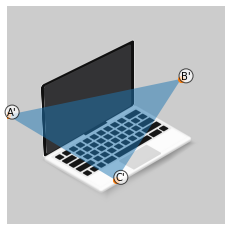

In [7]:
# plot source triangle
plot_triangle_with_labels(img, dst_triangle, dst_anotation_label)

In [8]:
# Find the minimal up-right bounding rectangle for definted triangle
bounding_source_rectangle = cv2.boundingRect(np.float32([src_triangle]))

In [9]:
# Find image bounded by bounding_rectangle
img_bounded_by_source_rectangle = img[bounding_source_rectangle[1]:bounding_source_rectangle[1] + bounding_source_rectangle[3],
                   bounding_source_rectangle[0]:bounding_source_rectangle[0] + bounding_source_rectangle[2]]

In [10]:
# Because we will consider only bounding_rectangle possition, let's change triangle corridanates 
src_triangle_in_bounding_rectangle = []
for i in range(0, 3):
    src_triangle_in_bounding_rectangle.append(((src_triangle[i][0] - bounding_source_rectangle[0]),
                                               (src_triangle[i][1] - bounding_source_rectangle[1])))

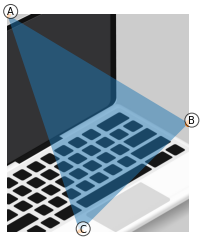

In [11]:
# plot bounded image with source triangle
plot_triangle_with_labels(img_bounded_by_source_rectangle, np.array(src_triangle_in_bounding_rectangle), src_anotation_label)

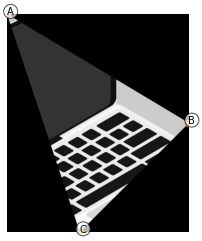

In [12]:
# create RGB mask of maxium size of bounding_rectangle. 
src_mask = np.zeros((bounding_source_rectangle[3], bounding_source_rectangle[2], 3), dtype = np.float32) 

# Fill triangle in mask
cv2.fillConvexPoly(src_mask, np.int32(src_triangle_in_bounding_rectangle), (1, 1, 1));

# plot mask
bounded_triangle = (src_mask * img_bounded_by_source_rectangle).astype(int)
plot_triangle_with_labels(bounded_triangle, np.array(src_triangle_in_bounding_rectangle), src_anotation_label, fill = False)

In [13]:
# Find bounded destination triangle

bounding_destination_rectangle = cv2.boundingRect(np.float32([dst_triangle]))
img_bounded_by_destination_rectangle = img[bounding_destination_rectangle[1]:bounding_destination_rectangle[1] + bounding_destination_rectangle[3],
                   bounding_destination_rectangle[0]:bounding_destination_rectangle[0] + bounding_destination_rectangle[2]]

dst_triangle_in_bounding_rectangle = []
for i in range(0, 3):
    dst_triangle_in_bounding_rectangle.append(((dst_triangle[i][0] - bounding_destination_rectangle[0]),
                                               (dst_triangle[i][1] - bounding_destination_rectangle[1])))

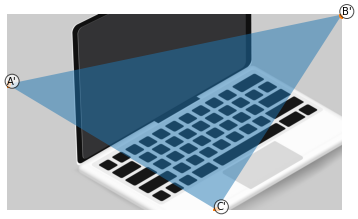

In [14]:
# plot bounded image with destination triangle
plot_triangle_with_labels(img_bounded_by_destination_rectangle, 
                          np.array(dst_triangle_in_bounding_rectangle), dst_anotation_label)

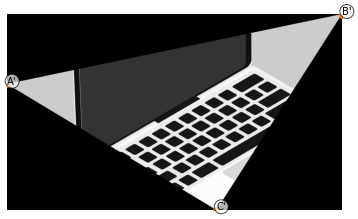

In [15]:
# create RGB mask of maxium size of bounding_rectangle. 
dst_mask = np.zeros((bounding_destination_rectangle[3], bounding_destination_rectangle[2], 3), dtype = np.float32) 

# Fill triangle in mask
cv2.fillConvexPoly(dst_mask, np.int32(dst_triangle_in_bounding_rectangle), (1, 1, 1));

# plot mask
dst_bounded_triangle = (dst_mask * img_bounded_by_destination_rectangle).astype(int)
plot_triangle_with_labels(dst_bounded_triangle, np.array(dst_triangle_in_bounding_rectangle), dst_anotation_label, fill = False)

In [16]:
# define geometric transformation which preserves collinearity
def affine_transform(src_img, src_triangle, dst_triangle, size) :
    
    # find the affine transform.
    warpMat = cv2.getAffineTransform( np.array(src_triangle).astype(np.float32), np.array(dst_triangle).astype(np.float32) )
    
    # apply the Affine Transform 
    output_img = cv2.warpAffine( src_img, warpMat, (size[0], size[1]))

    return output_img

In [17]:
# transform source triangle into destination triangle
warpImage_dest_to_src = affine_transform(img_bounded_by_destination_rectangle, 
                                  dst_triangle_in_bounding_rectangle,
                                  src_triangle_in_bounding_rectangle, 
                                  (bounding_source_rectangle[2], bounding_source_rectangle[3]))

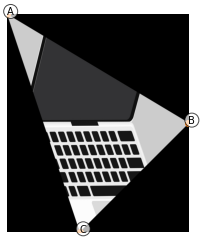

In [18]:
# plot transformed triangle
plot_triangle_with_labels((warpImage_dest_to_src * src_mask).astype(int),
                          np.array(src_triangle_in_bounding_rectangle),
                          src_anotation_label, fill = False)

In [19]:
# transform destination triangle into source triangle
warpImage_src_to_dest = affine_transform(img_bounded_by_source_rectangle, 
                                  src_triangle_in_bounding_rectangle, 
                                  dst_triangle_in_bounding_rectangle,
                                  (bounding_destination_rectangle[2], bounding_destination_rectangle[3]))

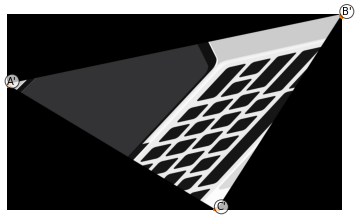

In [20]:
# plot transformed triangle
plot_triangle_with_labels((warpImage_src_to_dest * dst_mask).astype(int),
                          np.array(dst_triangle_in_bounding_rectangle),
                          dst_anotation_label, fill = False)

In [21]:
# to concatenate two images, first lets copy original image to not overwrite it.
concatenated_img = img.copy()

# concatenate two images - replace source_rectangle with warpImage_dest_to_src, to replaced only triangle -- use src_mask
concatenated_img[bounding_source_rectangle[1]:bounding_source_rectangle[1] + bounding_source_rectangle[3],
                 bounding_source_rectangle[0]:bounding_source_rectangle[0] + bounding_source_rectangle[2]]  = img_bounded_by_source_rectangle * ( 1 - src_mask ) + warpImage_dest_to_src * src_mask

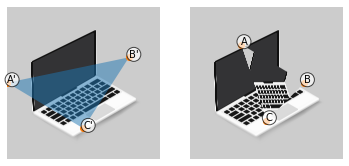

In [22]:
# Results
# We transform A', B', C' to A, B, C
f, ax = plt.subplots(1,2)
plot_triangle_with_labels(img, dst_triangle, dst_anotation_label, ax = ax[0])
plot_triangle_with_labels(concatenated_img, src_triangle, src_anotation_label, fill = False , ax = ax[1])

In [23]:
# sometimes we would like to overlap transformed triangle, that means 
# we do not want use only created warpImage_dest_to_src, but also original original_bounded_img

# definie alpha which allows you to see both
alpha = 0.5 

overlapping_img = ((1.0 - alpha) * (img_bounded_by_source_rectangle * src_mask.astype(int) ) + alpha * warpImage_dest_to_src * src_mask).astype(int)

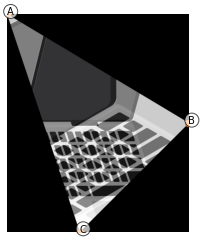

In [24]:
# plot overlapping img
plot_triangle_with_labels(overlapping_img,
                          np.array(src_triangle_in_bounding_rectangle),
                          src_anotation_label, fill = False , ax = plt)

In [25]:
# of course we can transform one image to another, to do that we will definie transform_triangle funtion

def transform_triangle(img1, img2, concatenated_img, src_triangle, dst_triangle, alpha = 0.5):
    # Find the minimal up-right bounding rectangle for both triangles
    bounding_source_rectangle = cv2.boundingRect(np.float32([src_triangle]))
    bounding_destination_rectangle = cv2.boundingRect(np.float32([dst_triangle]))

    # Find image bounded by bounding_rectangle
    img_bounded_by_source_rectangle = img1[bounding_source_rectangle[1]:bounding_source_rectangle[1] + bounding_source_rectangle[3],
                   bounding_source_rectangle[0]:bounding_source_rectangle[0] + bounding_source_rectangle[2]]
    img_bounded_by_destination_rectangle = img2[bounding_destination_rectangle[1]:bounding_destination_rectangle[1] + bounding_destination_rectangle[3],
                   bounding_destination_rectangle[0]:bounding_destination_rectangle[0] + bounding_destination_rectangle[2]]

    
    # Because we will consider only bounded rectangles possition, let's change triangles corridanates 
    src_triangle_in_bounding_rectangle = []
    dst_triangle_in_bounding_rectangle = []
    
    for i in range(0, 3):
        src_triangle_in_bounding_rectangle.append(((src_triangle[i][0] - bounding_source_rectangle[0]),
                                                   (src_triangle[i][1] - bounding_source_rectangle[1])))
        dst_triangle_in_bounding_rectangle.append(((dst_triangle[i][0] - bounding_destination_rectangle[0]),
                                               (dst_triangle[i][1] - bounding_destination_rectangle[1])))
        
    # create RGB mask of maxium size of bounding_rectangle. 
    src_mask = np.zeros((bounding_source_rectangle[3], bounding_source_rectangle[2], 3), dtype = np.float32) 

    # Fill triangle in mask
    cv2.fillConvexPoly(src_mask, np.int32(src_triangle_in_bounding_rectangle), (1, 1, 1));

    # define bounded triangle
    bounded_triangle = (src_mask * img_bounded_by_source_rectangle).astype(int)
    
    # transform source triangle into destination triangle
    warpImage_dest_to_src = affine_transform(img_bounded_by_destination_rectangle, 
                                  dst_triangle_in_bounding_rectangle,
                                  src_triangle_in_bounding_rectangle, 
                                  (bounding_source_rectangle[2], bounding_source_rectangle[3]))

    # create overlapping img
    overlapping_img = ((1.0 - alpha) * (img_bounded_by_source_rectangle ) + alpha * warpImage_dest_to_src).astype(int)

    # concatenate two images - replace source_rectangle with warpImage_dest_to_src, to replaced only triangle -- use src_mask
    concatenated_img[bounding_source_rectangle[1]:bounding_source_rectangle[1] + bounding_source_rectangle[3],
                     bounding_source_rectangle[0]:bounding_source_rectangle[0] + bounding_source_rectangle[2]]  = img_bounded_by_source_rectangle * ( 1 - src_mask ) + overlapping_img * src_mask
    
    return concatenated_img, warpImage_dest_to_src

In [26]:
img1 = cv2.cvtColor(cv2.imread('laptop_black.jpg'), cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(cv2.imread('laptop_pink.jpg'), cv2.COLOR_BGR2RGB)

In [27]:
# Definie source triangle
A = [int(img.shape[1]/3), int(img.shape[0]/4)]
B = [int(img.shape[1]*3/4), int(img.shape[0]/2)]
C = [int(img.shape[1]/2), int(img.shape[0]/4*3)]
src_anotation_label = ['A', 'B', 'C']
src_triangle = np.array([A, B, C])

In [28]:
# Definie destination triangle
A_prim = [0, int(img.shape[0]/2)]
B_prim = [int(img.shape[1]*4/5), int(img.shape[0]/3)]
C_prim = [int(img.shape[1]/2), int(img.shape[0]*4/5)]
dst_anotation_label = ["A'", "B'","C'",]
dst_triangle = np.array([A_prim, B_prim, C_prim])

In [29]:
concatenated_img, warpImage_dest_to_src = transform_triangle(img1, img2, img1.copy(), src_triangle, dst_triangle, alpha = 0.5)

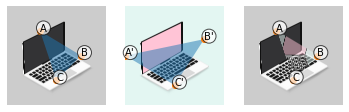

In [30]:
# We transform A', B', C' (img2) to A, B, C (img1)
f, ax = plt.subplots(1,3)
plot_triangle_with_labels(img1, src_triangle, src_anotation_label, ax = ax[0])
plot_triangle_with_labels(img2, dst_triangle, dst_anotation_label, ax = ax[1])
plot_triangle_with_labels(concatenated_img, src_triangle, src_anotation_label, fill = False, ax = ax[2])